# Generating Synthetic PV Power Time Series

In [1]:
import os
import yaml
import pandas as pd
import pvlib
import matplotlib.pyplot as plt

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
def load_config(config_path):
    with open(config_path, "r") as file:
        return yaml.safe_load(file)

In [9]:
config_path = "config.yaml"
config = load_config(config_path)

dir = config['data']['final_data']
params = config['synth']

installed_power = 100
surface_tilt = 10
surface_azimuth = 10
gamma_pdc = -0.0035
albedo = 0.25

In [10]:
files = os.listdir(dir)
file = files[0]

df = pd.read_csv(os.path.join(dir, file))
df['timestamp'] = pd.to_datetime(df['timestamp'])
df.set_index('timestamp', inplace=True)

df.drop(['  QN_x', '  QN_y', '  QN'], axis=1, inplace=True)

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 79200 entries, 2023-05-26 00:00:00 to 2024-11-25 23:50:00
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   STATIONS_ID    79200 non-null  int64  
 1   PP_10          79200 non-null  float64
 2   TT_10          79200 non-null  float64
 3   TM5_10         79200 non-null  float64
 4   RF_10          79200 non-null  float64
 5   TD_10          79200 non-null  float64
 6   FF_10          79200 non-null  float64
 7   DD_10          79200 non-null  int64  
 8   DS_10          79200 non-null  float64
 9   GS_10          79200 non-null  float64
 10  SD_10          79200 non-null  float64
 11  LS_10          79200 non-null  int64  
 12  Stationshoehe  79200 non-null  float64
 13  geoBreite      79200 non-null  float64
 14  geoLaenge      79200 non-null  float64
dtypes: float64(12), int64(3)
memory usage: 9.7 MB


In [ ]:
def generate_pv_power(data: pd.DataFrame, 
                      params: list,
                      installed_power: float,
                      surface_tilt: float, 
                      surface_azimuth: float, 
                      albedo: float,
                      gamma_pdc: float
                      ) -> pd.Series:
    
    # calculate pressure
    #pressure = pvlib.atmosphere.alt2pres(elevation)
    dhi = data[params['param_dhi']]
    ghi = data[params['param_ghi']]
    pressure = data[params['param_pressure']]
    temperature = data[params['param_temperature']]
    v_wind = data[params['param_v_wind']]
    latitude = data[params['param_latitude']]
    longitude = data[params['param_longitude']]
    elevation = data[params['param_elevation']]
    
    #Get solar position
    solpos = pvlib.solarposition.get_solarposition(
        time=data.index,
        latitude=latitude,
        longitude=longitude,
        altitude=elevation,
        temperature=temperature,
        pressure=pressure,
    )
    solar_zenith = solpos['zenith']
    solar_azimuth = solpos['azimuth']
    
    # GHI und DHI in W/m^2 umrechnen 
    
    # get dni from ghi, dni and zenith
    dni = pvlib.irradiance.dni(ghi=ghi,
                               dhi=dhi,
                               zenith=solar_zenith)
    
    # Get total irradiance
    total_irradiance = pvlib.irradiance.get_total_irradiance(
        surface_tilt=surface_tilt,
        surface_azimuth=surface_azimuth,
        solar_zenith=solar_zenith,
        solar_azimuth=solar_azimuth,
        dni=dni,
        ghi=ghi,
        dhi=dhi,
        dni_extra=pvlib.irradiance.get_extra_radiation(data.index),
        albedo=albedo,
        model='haydavies',
    )
    # Calculate solar power
    cell_temperature = pvlib.temperature.faiman(total_irradiance['poa_global'], 
                                                temperature,
                                                v_wind, 
                                                u0=25.0, 
                                                u1=6.84)
    
    power_dc = pvlib.pvsystem.pvwatts_dc(total_irradiance['poa_global'], 
                                         cell_temperature, 
                                         installed_power,
                                         gamma_pdc=gamma_pdc, 
                                         temp_ref=25.0)
    
    return pvlib.inverter.pvwatts(power_dc, 
                                  installed_power, 
                                  eta_inv_nom=0.96, 
                                  eta_inv_ref=0.9637)

In [13]:
power = generate_pv_power(data=df, 
                          params=params, 
                          installed_power=installed_power, 
                          surface_tilt=surface_tilt,
                          surface_azimuth=surface_azimuth, 
                          albedo=albedo,
                          gamma_pdc=gamma_pdc)

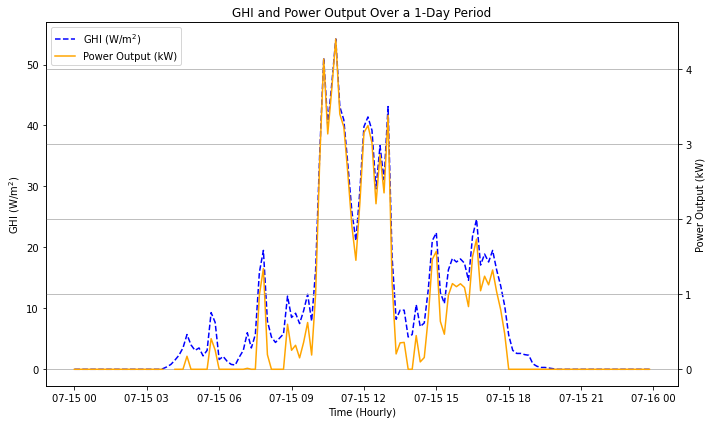

In [19]:
i = 50
day = 6 * 24

fig, ax1 = plt.subplots(figsize=(10, 6))

line1, = ax1.plot(
    df[params['param_ghi']][i * day: day * (i + 1)],
    label="GHI (W/m$^2$)",
    color="blue",
    linestyle='--'
)
ax1.set_xlabel("Time (Hourly)")
ax1.set_ylabel("GHI (W/m$^2$)")
ax1.tick_params(axis='y')

ax2 = ax1.twinx()
line2, = ax2.plot(
    power[i * day: day * (i + 1)],
    label="Power Output (kW)",
    color="orange"
)
ax2.set_ylabel("Power Output (kW)")
ax2.tick_params(axis='y')

lines = [line1, line2]
labels = [line.get_label() for line in lines]
ax1.legend(lines, labels, loc="upper left")

plt.title("GHI and Power Output Over a 1-Day Period")
fig.tight_layout()
plt.grid(True)

plt.show()